In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

#### LOAD AND MERGE DATA ####

recall_df = pd.read_csv('test.csv') #original data set pulled from FDA site containined recalled items
allinspections_df = pd.read_excel("fda_inspections.xlsx") #recently found all inspections data 

# Step 1: Create recalled_bool using FEI Number
allinspections_df['recalled_bool'] = allinspections_df['FEI Number'].apply(
    lambda x: 1 if x in recall_df['FIRMFEINUM'].values else 0
)

# Step 2: (OPTIONAL) Override or combine with Classification logic
# If Classification is OAI or VAI, you may consider it risky even if not recalled
class_to_check = ['Official Action Indicated (OAI)', 'Voluntary Action Indicated (VAI)']
allinspections_df['classification_flag'] = allinspections_df['Classification'].isin(class_to_check).astype(int)

# Combine classification with recall label if needed (comment out if you don't want this)
# allinspections_df['recalled_bool'] = allinspections_df[['recalled_bool', 'classification_flag']].max(axis=1)

In [5]:

#### FEATURE ENGINEERING ####

# Convert date
allinspections_df['Inspection End Date'] = pd.to_datetime(allinspections_df['Inspection End Date'])
allinspections_df = allinspections_df.sort_values(['FEI Number', 'Inspection End Date'])

# Date-based features
allinspections_df['inspection_year'] = allinspections_df['Inspection End Date'].dt.year
allinspections_df['inspection_month'] = allinspections_df['Inspection End Date'].dt.month
allinspections_df['inspection_dayofweek'] = allinspections_df['Inspection End Date'].dt.dayofweek
allinspections_df['inspection_quarter'] = allinspections_df['Inspection End Date'].dt.quarter
allinspections_df['week_of_year'] = allinspections_df['Inspection End Date'].dt.isocalendar().week

def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    return 'Fall'

allinspections_df['inspection_season'] = allinspections_df['inspection_month'].apply(get_season)

# Days since last inspection per FEI Number
allinspections_df['days_since_last_inspection'] = allinspections_df.groupby('FEI Number')['Inspection End Date'].diff().dt.days
allinspections_df['days_since_last_inspection'] = allinspections_df['days_since_last_inspection'].fillna(-1)

In [6]:
#### PREPARE DATA FOR MODELING ####

# Columns to use for modeling
features = [
    'Posted Citations', 'Classification', 'Project Area', 'Product Type', 'State',
    'Fiscal Year', 'inspection_year', 'inspection_month', 'inspection_dayofweek',
    'inspection_quarter', 'week_of_year', 'inspection_season', 'days_since_last_inspection'
]

df_model = allinspections_df[features + ['recalled_bool']].dropna()

# Convert Posted Citations to binary (1 if there are any citations posted)
df_model['Posted Citations'] = df_model['Posted Citations'].notnull().astype(int)

# Encode categoricals
categorical_cols = ['Classification', 'Project Area', 'Product Type', 'State', 'inspection_season']
for col in categorical_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])


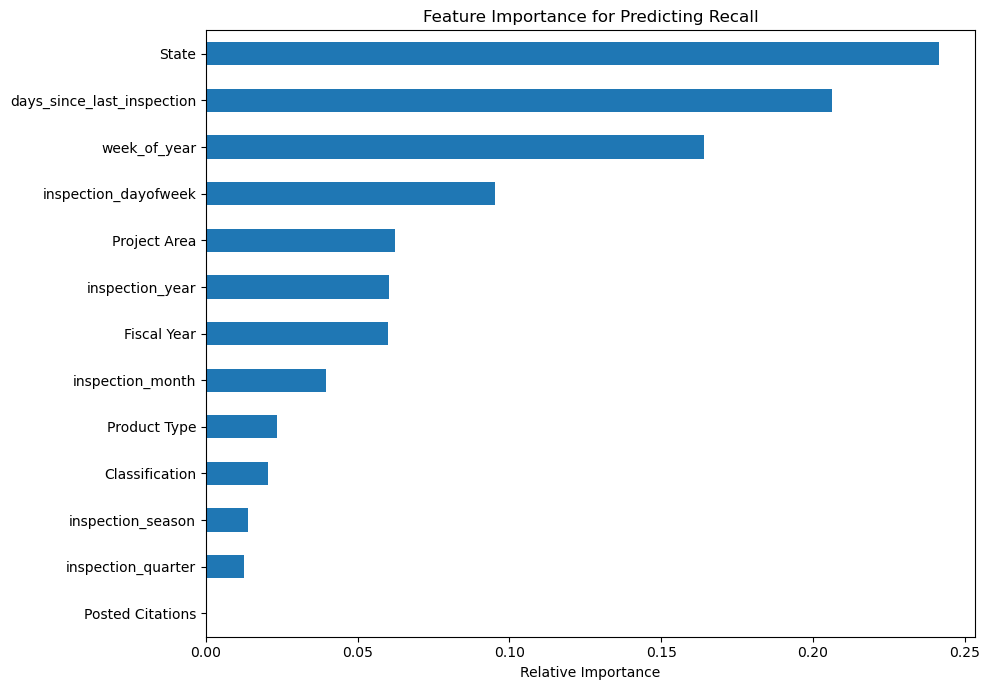

In [7]:
#### MODELING ####

X = df_model.drop('recalled_bool', axis=1)
y = df_model['recalled_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10,7), title='Feature Importance for Predicting Recall')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()